# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Necessary Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
50455,23,Richard Pike,", 61, British chemist.",https://en.wikipedia.org/wiki/Richard_Pike,5,2011,July,None,None,chemist,None,None,None,None,None,None,None,None,None,61.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
110289,31,Kiyoshi Sasabe,", 62, Japanese film director .",https://en.wikipedia.org/wiki/Kiyoshi_Sasabe,3,2020,March,", ,",None,film director,None,None,None,None,None,None,None,None,None,62.0,None,Japan,None,", ,"
65217,8,Orlando Álvarez,", 78, Chilean lawyer and writer, Judge of the Supreme Court .",https://en.wikipedia.org/wiki/Orlando_%C3%81lvarez_(lawyer),1,2013,December,,None,lawyer writer,Judge of the Supreme Court,None,None,None,None,None,None,None,None,78.0,None,Chile,None,1998 2009
29806,23,Eloy de la Iglesia,", 62, Spanish film director.",https://en.wikipedia.org/wiki/Eloy_de_la_Iglesia,4,2006,March,None,None,film director,None,None,None,None,None,None,None,None,None,62.0,None,Spain,None,None
42286,27,Tapani Aartomaa,", 75, Finnish professor and graphic designer.",https://en.wikipedia.org/wiki/Tapani_Aartomaa,2,2009,October,None,None,professor graphic designer,None,None,None,None,None,None,None,None,None,75.0,None,Finland,None,None


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   day                132652 non-null  object 
 1   name               132652 non-null  object 
 2   info               132652 non-null  object 
 3   link               132652 non-null  object 
 4   num_references     132652 non-null  object 
 5   year               132652 non-null  int64  
 6   month              132652 non-null  object 
 7   info_parenth       49830 non-null   object 
 8   info_1             35 non-null      object 
 9   info_2             132604 non-null  object 
 10  info_3             62571 non-null   object 
 11  info_4             12605 non-null   object 
 12  info_5             1497 non-null    object 
 13  info_6             216 non-null     object 
 14  info_7             31 non-null      object 
 15  info_8             6 non-null       object 
 16  in

<IPython.core.display.Javascript object>

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [6]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

### `num_references`

In [7]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

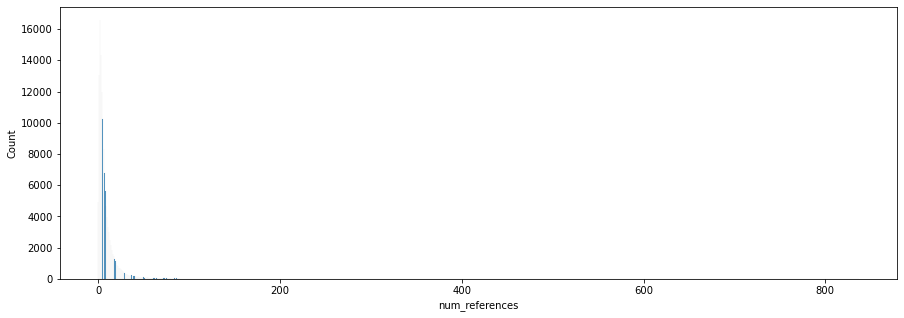

<IPython.core.display.Javascript object>

In [8]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [9]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since House of Representatives,None,politician Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,Prime Minister,None,revolutionary politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [10]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [11]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

In [12]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
    "https://en.wikipedia.org/wiki/Mbah_Gotho",
]

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 where Entry Link Points to a List Page

In [13]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
65960,13,Waldemar von Gazen,", 96, German officer in the Wehrmacht during World War II and Iron Cross recipient.",https://en.wikipedia.org/wiki/Waldemar_von_Gazen,1,2014,January,None,None,officer in the Wehrmacht during World War II Iron Cross recipient,None,None,None,None,None,None,None,None,None,96.0,None,Germany,None,None
46407,7,Klaus Feldt,", 98, German World War II .",https://en.wikipedia.org/wiki/Klaus_Feldt,1,2010,September,corvette captain,None,World War II,None,None,None,None,None,None,None,None,None,98.0,None,Germany,None,corvette captain


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [14]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.734719
std          19.061117
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

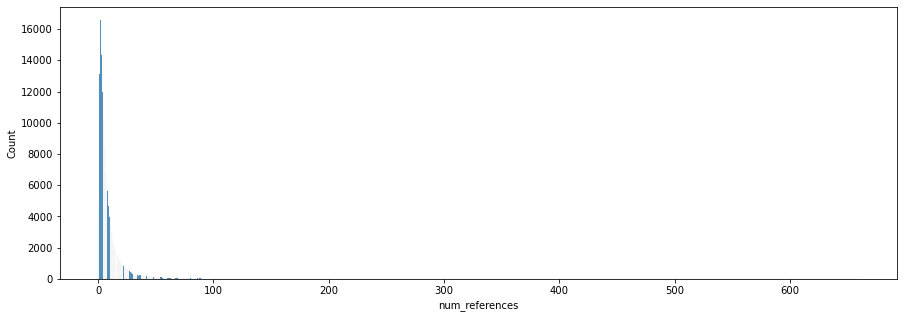

<IPython.core.display.Javascript object>

In [15]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

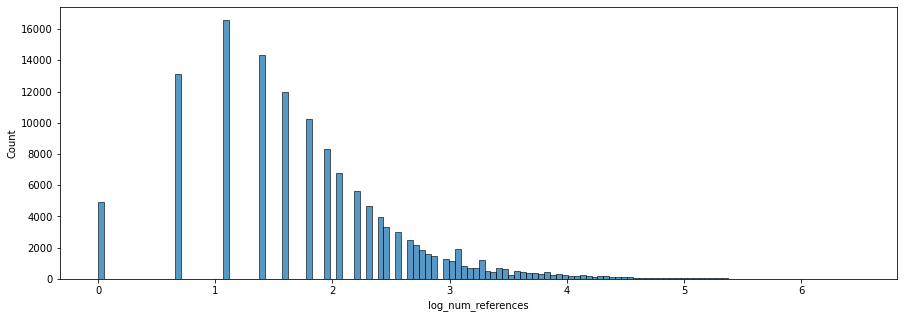

<IPython.core.display.Javascript object>

In [16]:
# Adding column for log_num_references
df["log_num_references"] = df["num_references"].apply(lambda x: np.log(x + 1))

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

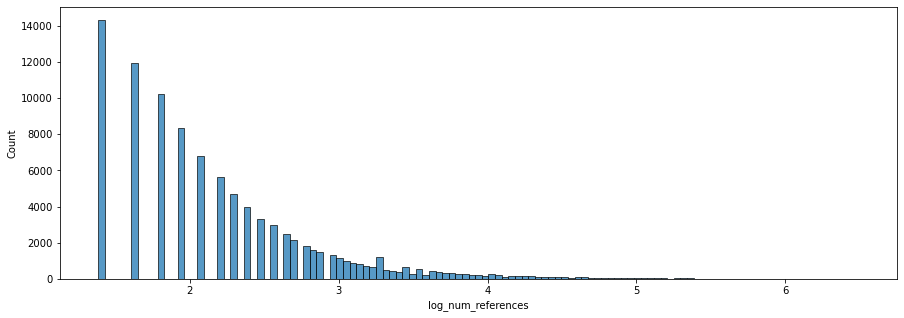

<IPython.core.display.Javascript object>

In [17]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.

We will take the following approach:
1. create and check a list of unique values in `info_2` using value_counts, in ascending order.
2. using the pop() method, add each role to it's associated category's list, below, taking care to screen and clarify values that may have multiple meanings, and adding those clarified values to the lists as indicated.
3. combine the lists for each category into one dictionary.
4. Create a corresponding column for each category, initialized equal to 0.
5. search for the values in the dictionary and change the category column to 1 if at least 1 match is found.
6. Rather than importing our previous `other_species` list, we will start anew and include it in our search here.

#### Restricting our Dataset to Entries with More than 2 References

In [18]:
# Limiting the dataset to entries with > 2 references
df = df[df["num_references"] > 2]
print(f"There are {len(df)} remaining entries in the dataframe.")

There are 98061 remaining entries in the dataframe.


<IPython.core.display.Javascript object>

#### Finding `known_for` Roles in `info_1`

In [19]:
# Obtaining values for column and their counts
roles_list = df["info_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [20]:
# Code to check each value
roles_list.pop()

'early'

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [21]:
# Creating lists for each category
politics_govt_law = [  # Contains leader
    "political advisor",
    "politician",
    "political leader",
    "political",
    "politics",
    "labor civil rights leader",
    "civil rights leader",
    "tribal leader",
    "Māori leader",
    "community leader",
    "al Qaeda leader",
    "separatist leader",
    "indigenous leader",
    "opposition leader",
    "Taliban leader",
    "communist leader",
    "Al Qaeda leader",
    "coup leader",
    "activist leader",
    "nationalist leader",
    "Knights of the Ku Klux Klan leader",
    "public policy business leader",
    "leader in the disability rights movement",
    "civic leader",
    "peasant leader",
    "leader of Group",
    "feminist",
    "women rights activist",
    "independence leader",
    "revolutionary leader",
    "traditional leader",
    "coupist",
    "Māori leader",
    "Ga leader",
    "environmental leader",
    "urban homesteading leader",
    "civil leader",
    "Islamist leader",
    "Islamist Al Shabaab leader",
    "Shi'a Islamic leader",
    "Alaska Native leader",
    "Native leader",
    "Corsican nationalism leader",
    "independentism leader",
    "diplomat",
    "deputy leader of al Qaeda",
    "Maoist leader",
    "Ku Klux Klan leader",
    "leader of the Black Panther Party",
    "senior Hamas leader",
    "Hamas leader",
    "black nationalist leader",
    "revolutionary socialist workers' leader",
    "social activist",
    "chairman of the Communist Party",
    "leader of Naxalite",
    "leader of the nazi National Socialist Women League",
    "environmental activist",
    "activist",
    "human rights",
    "civil rights movement leader",
    "civil rights",
    "founder of Hamas",
    "top official in the rebel government",
    "leader of the Communist Party",
    "Prime Minister",
    "prime minister",
    "Prime minister",
    "one of the leaders of the national emancipation movement",
    "native leader",
    "royal prince",
    "Communist leader",
    "junta leader",
    "statesman",
    "stateswoman",
    "Founder first leader of",
    "leader of the GDR",
    "Party student leader later a neo  figure",
    "leader of Communist Party",
    "wife of  leader Leonid Brezhnev",
    "leader of  coup d'état",
    "environmentalist",
    "leader of the People Republic of",
    "leader of the Muslim Brotherhood",
    "nationalist leader of the Grey Wolves",
    "Hitler Youth leader",
    "advocate for women education",
    "Inuit leader",
    "life peer",
    "public leader",
    "leader of Beijing Communist Party",
    "local government leader",
    "government leader",
    "fascist leader of the Independent State of  in World War II",
    "civil servant",
    "congressman",
    "congresswoman",
    "leader of the FNLA",
    "Western Shoshone leader",
    "Chief Minister",
    "white supremacist leader",
    "secular humanist leader",
    "campaigner",
    "health official",
    "disability rights leader",
    "leader and country music",  # singer will capture arts for this entry which is also political
    "Makah leader",
    "First Nations leader",
    "republican",
    "Republican leader",
    "Republican",
    "Democratic leader",
    "Democrat",
    "democrat",
    "coup d'état leader",
    "Communist revolutionary figure",
    "women rights advocate",
    "socialist leader",
    "nationalist",
    "social leader",
    "Sultan",
    "sultan",
    "criminal lawyer",
    "criminal defense lawyer",
    "defense lawyer",
    "lawyer",
    "a deputy leader of the Party of Regions",
    "leader of the Progressive Unionist Party",
    "parliamentarian",
    "barrister",
    "revolutionary",
    "leader of the Islamic Renaissance Party of istan",
    "separatist",
    "leader of Al Qaeda",
]

arts = [  # Contains leader
    "choral",
    "conductor",
    "journalist",
    "bandleader",
    "band leader",
    "orchestra leader",
    "Māori performing arts leader",
    "blues saxophonist",
    "blues",
    "saxophonist",
    "saxophone player",
    "steel guitarist",
    "bass guitarist",
    "guitarist",
    "guitar player",
    "bass guitar player",
    "bassist",
    "bassoonist",
    "bassoon player",
    "reed player",
    "Māori kapa haka leader",
    "clarinetist",
    "clarinet player",
    "swing",
    "musician",
    "calligrapher",
    "film producer",
    "soul",
    "jazz",
    "singer",
    "vocalist",
    "R&B",
    "architect",
    "accordion player",
    "accordion",
    "arts leader",
    "bluegrass",
    "mandolinist",
    "singer wife of leader founder of Ladysmith Black Mambazo",
    "broadcaster",
    "pianist",
    "writer",
    "novelist",
    "cultural leader",
    "trumpeter",
    "trumpet player",
    "dance",
    "arranger",
    "actress",
    "beauty queen",  # Contains queen
    "founder of exotica musical genre",
    "leader of The Prisonaires",
    "talent agent",
    "percussionist",
    "drummer",
    "leader of the Mary Kaye Trio",
    "salsa",
    "rock musician",
    "trombonist",
    "music executive",
    "media executive",
    "broadcasting executive",
]
sports = [
    "basketball",
    "Olympics",
    "Olympic",
    "Olympian",
    "gymnast",
    "sports",
    "cheerleader",
    "motor racing driver team leader",
    "cricket administrator",
    "yoga instructor",
    "football goalkeeper",
    "martial artist",  # Before arts
    "martial arts",
]
sciences = [
    "research scientist",  # Contains research
    "scientist",  # Before law_enf_military_operator
    "nurse",
    "physicist a leader in controlled fusion research",
    "nuclear physicist",
    "physicist",
    "engineer",
    "physician",
    "group leader in the Manhattan Project",
    "ophthalmologist",
    "psychiatrist",
]

business_farming = [  # Contains leader
    "labor leader",
    "trade union leader",
    "labor union leader",
    "union leader",
    "farmers' union leader",
    "farming union leader",
    "union leader",
    "farming leader",
    "farmers' leader",
    "realtor",
    "trade unionist",
    "stamp printer",
    "industrialist",
    "businesswoman",
    "businessman",
    "farmer",
    "financier",
    "business executive",
    "labour union leader",
]
academia_humanities = [
    "education leader",
    "academic leader",
    "historical revisionist",
    "historian",
    "professor",
    "Professor",
    "President of Hebrew Union College",
    "leader president of Ner",
    "advocate for disadvantaged students",
]  # Contains leader

law_enf_military_operator = [  # Contains leader
    "military leader",
    "rebel leader",
    "militant leader",
    "guerrilla leader",
    "army leader",
    "paramilitary leader",
    "coup leader",
    "Resistance leader",
    "militia leader",
    "OSS agent leader of Operation Halyard",
    "internal security leader",
    "mercenary leader",
    "leader of Jabhat al Nusra",
    "Lashkar e Jhangvi leader",
    "warlord",
    "insurgent commander",
    "resistance leader",
    "freedom fighter",
    "leader Secretary General of the Popular Front for the Liberation of",
    "NASA space science administrator a leader in satellite communications",
    "general military",
    "Air Force leader",
    "lieutenant general",
    "police general",
    "leader of the Bielski partisans",
    "Hamas military",
    "leader of  Tigers",
    "leader of the Anbar Salvation Council",
    "leader of Anbar Salvation Council",
    "army general",
    "army officer",
    "Sunni Islamist militant",
    "veteran",
    "leader of the Izz ad Din al Qassam Brigades",
    "Army leader",
    "leader of the Boricua Popular Army",
    "Army general",
    "PLO leader",
    "resistance movement leader",
    "leader of the  Intelligence Service",
    "Republican Guard",  # Must come before politics_govt_law
    "bomber pilot",
    "private security contractor",
]
spiritual = [  # Contains leader
    "religious sect leader",
    "religious leader",
    "spiritual leader",
    "Christian leader",
    "Islamic leader",
    "sect leader",
    "Mormon leader",
    "church leader",
    "Seventh day Adventist leader",
    "religious cult leader",
    "cult leader",
    "Latter day Saints leader",
    "theosophist leader",
    "Hare Krishna leader",
    "Mormon women leader",
    "Zionist leader",
    "leader in The Church of Jesus Christ of Latter day Saints",
    "Catholic leader",
    "Muslim leader",
    "Sufi leader",
    "clergyman",
    "cleric",
    "clergy",
    "Catholic fraternity leader",
    "Baháʼí Faith leader",
    "Qadiriyya leader",
    "evangelical leader",
    "missionary",
    "Shia leader",
    "Jewish leader",
    "pastor",
    "Zionist",
    "Sikh leader",
    "Chief Rabbi",
    "leader of the Branch Davidian sect",
    "Jewish rabbi",
    "leader of religious movement",
    "theologian",
    "leader of the  cult group",
    "widow of religious",
    "Baptist preacher",
    "Black Muslim",
    "Neopagan leader",
    "leader in the LDS Church",
    "Sikh",
    "Rabbinical College for over  years",
    "Catholic lay leader",
    "monk",
    "Presbyterian leader ",
    "Buddhist leader",
    "young earth creationist leader",
    "leader of the Apostolic United Brethren",
    "founder of the Holy Spirit Movement",
    "Baptist minister",
    "Sufi",
]
social = [  # Contains leader
    "scout leader",
    "scouting leader",
    "Scout leader",
    "Girl Guides leader",
    "socialite",
    "philanthropist",
    "leader of the international Scouting movement",
    "leader of the Muscular Dystrophy Association",
]

crime = [  # Contains leader
    "mafia leader",
    "mafia gang leader",
    "Sinaloa Cartel leader",
    "gang leader",
    "convicted felon",
    "convicted murderer",
    "serial killer",
    "convicted attempted murderer",
    "drug cartel leader",
    "cartel leader",
    "convicted war criminal",
    "suspected ringleader of the November  Paris attacks",
    "convicted terrorist",
    "drug smuggler",
    "convicted murderer",
    "mobster",
    "islamist terrorist group leader",
    'leader of the " Mafia"',
    "sex offender",
    "leader Holocaust perpetrator",
    "leader of the Sinaloa Cartel",
    "drug lord",
]
event_record_other = [  # Contains leader
    "student leader",
]
other_species = [
    "chimpanzee",
]

<IPython.core.display.Javascript object>

In [22]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "leader" in df.loc[index, "info"]], "info_2",
# ].value_counts()[500:600]

<IPython.core.display.Javascript object>

In [23]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "social leader" in df.loc[index, "info"]]]

<IPython.core.display.Javascript object>

In [24]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "separatist rebel leader"]

<IPython.core.display.Javascript object>

#### Observations:
- Clarifying values for "leader" provided us with a good collection of lists with which to begin the search.
- We will first drop an entry that has a link pointing to a page for a list of individuals, then search `info_2` with the lists combined into a dictionary, `known_for_dict_1`.

#### Dropping Links that Point to a Page with a List of Individuals

In [25]:
# # Dropping entries that have link pointing to list page
# row_to_drop = df[df["link"] == "https://en.wikipedia.org/wiki/Thabet_bin_Laden"].index

# df.drop(row_to_drop, inplace=True)
# df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_1` Dictionary of Category Keys and Specific Role Lists of Values

In [26]:
# Combining separate lists into one dictionary
known_for_dict_1 = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Initializing `known_for` Category Columns

In [27]:
# Creating columns for each category
for category in known_for_dict_1:
    df[category] = 0

# Checking a sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
77265,30,Hugo Rasmussen,", 74, Danish jazz musician.",https://en.wikipedia.org/wiki/Hugo_Rasmussen,25,2015,August,None,None,jazz musician,None,None,None,None,None,None,None,None,None,74.0,None,Denmark,None,None,3.258097,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict_1`

In [28]:
%%time

# Dictionary version
search_dict = known_for_dict_1

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['politics_govt_law'] ==1].sample(2)

CPU times: total: 3min 52s
Wall time: 3min 52s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
81639,19,Patricio Aylwin,", 97, Chilean politician, President .",https://en.wikipedia.org/wiki/Patricio_Aylwin,25,2016,April,,None,,President,None,None,None,None,None,None,None,None,97.0,None,Chile,None,1990 1994,3.258097,0,0,0,0,0,0,0,0,1,0,0,0
40429,11,Abel Goumba,", 82, Central African politician, Prime Minister .",https://en.wikipedia.org/wiki/Abel_Goumba,19,2009,May,", , Vice President",None,,Prime Minister,None,None,None,None,None,None,None,None,82.0,None,Central African Republic,None,"1957 1958, 1959, 2003 Vice President 2003 2005",2.995732,0,0,0,0,0,0,0,0,1,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [29]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_1.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 52339 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- About half of entries have at least one `known_for` category from the first search on `info_2` with `known_for_dict_1`.
- We will proceed to do repeated iterations on `info_2`, making a new `known_for_dict` for each iteration.

#### Finding `known_for` Roles in `info_2`

In [30]:
# Obtaining values for column and their counts
roles_list = df["info_2"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [31]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [32]:
# Creating lists for each category
politics_govt_law = [
    "minister of science",  # Before sciences
    "Solicitor General",
    "jurisprudence",
    "Justice Minister",
    "SEC commissioner",
    "legal adviser to Barack Obama",
    "legalisation",
    "economist",
    "agricultural economist",
    "first woman appointed to the Queen Bench Division of the High Court",
    "State judge prosecutor at the Nuremberg war crimes trials",
    "senior federal judge",
    "federal judge",
    "district judge",
    "chief judge",
    "senior judge",
    "indigenous judge",
    "Lord Chief Justice",
    "Supreme Court judge",
    "District Judge of the District Court",
    "judge of the District Court",
    "judge",
    "Official IRA",
    "first Chief of Staff",
    "Chief of Staff Treasury Secretary during the Reagan administration",
    "Deputy Chief of Staff",
    "Chief of Staff to the",
    "Chief of Staff to President Alpha Condé",
    "social commentator",
    "jurist",
    "Circuit Judge of the Court of Appeals for the First Circuit",
    "first female chief justice of the Washington Supreme Court",
    "District Judge",
    "chief justice of the Supreme Court",
    "World Court judge",
    "peer",
    "federal prosecutor",
    "prosecutor",
    "vice president of the International Court of Justice vice president of the International Committee",
    "social critic",  # Must go before arts
]

arts = [
    "artist",
    "actor",
    "poet",
    "composer",
    "painter",
    "acting coach",
    "science fiction",  # Before sciences
    "biographer",
    "literary critic",
    "critic",
    "television presenter",
    "presenter",
    "folk",
    "stage director",
    "harpsichordist",
    "sculptor",
    "operatic soprano",
    "soprano",
    "Kantor",
    "juvenile literature",
    "painter",
    "engraver",
    "organist",
    "filmmaker",
    "film director",
    "photographer",
    "screen",
    "playwright",
    "cartoonist",
    "comedian",
    "comic book",
    "model",
    "publisher",
    "fashion designer",
    "record producer",
]
sports = [
    "footballer",
    "football player manager",
    "football player coach",
    "football coach",
    "football player",
    "baseball player",
    "cricketer",
    "mountaineer",
    "dog show judge",  # Must come before politics_govt_law
    "ice hockey player",
    "professional wrestler",
    "wrestler",
    "boxer",
    "rugby league player",
    "rugby union player",
    "rugby player",
    "racing cyclist",
    "cyclist",
    "swimmer",
    "athlete",
    "racing driver",
    "tennis player",
    "rower",
    "golfer",
    "sprinter",
]
sciences = [
    "of science",
    "medical researcher",
    "medical doctor",
    "sociologist",
    "neurosurgeon",
    "chemist",
    "geneticist",
    "mathematician",
    "psychologist",
    "archaeologist",
    "astronomer",
]

business_farming = [
    "entrepreneur",
    "banker",
    "residential contractor",
    "developer contractor",
    "building contractor",
    "hauling contractor",
    "contractor",
]
academia_humanities = [
    "linguist",
    "Master of Clare College",
    "Regius of Law",
    "Director of the Institute of Law",
    "Academy of Social Sciences",
    "Dean of the UCL Faculty of Laws",
    "translator",
    "japanologist",
    "Japanologist",
    "pedagogue",
    "academic administrator",  # contains administrator
    "classicist",
    "academic director",  # contains director,
    "university president",  # contains president
    "philosopher",
    "schoolmaster",
    "educator",
    "college president",  # contains president
    "sinologist",
    "librarian",
    "academic",
    "anthropologist",
]
law_enf_military_operator = [
    "Chief of Staff of the IRA",
    "Army officer Chief of Staff",
    "Chief of Staff of the Air Force",
    "Deputy Chief of Staff of the People Liberation Army",  # Must go before politics_govt_law
    "Chief of Staff of the Defense Forces",
    "Vice Chief of Staff of the Army",
    "Chief of Staff of the People National Army",
    "Air Marshal",
    "Chief of Staff Defence Staff Chief",
    "Chief of Staff Ground Self Defense Force",
    "Chief of Staff for UNAMSIL",
    "Armed Forces Chief of Staff",
    "Chief of Staff of the Guangzhou Military Region",
    "Chief of Staff of the National Liberation Army",
    "military intelligence officer",
    "air force officer",
    "Air Force major general",
    "military officer",
    "intelligence officer",
    "military subcontractor",  # Must go before business
]
spiritual = [
    "Anglican priest",
    "priest",
    "Anglican prelate",
    "prelate",
]
social = [
    "director for the Atheists",  # contains director
    "Catholic prelate",
    "prelate",
]
crime = [
    "commodities trader illegal oil broker",  # Before politics_govt_law
    "tax evader",
    "cannabis smuggler",
    "smuggler",
]
event_record_other = [
    "anencephalic baby who became the center of a medical controversy",  # contains medical
]
other_species = []

<IPython.core.display.Javascript object>

In [33]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "judge" in df.loc[index, "info"]], :][0:100]

<IPython.core.display.Javascript object>

In [34]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "Chief of Staff" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

In [35]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "Chief of Staff to the" in df.loc[index, "info"]], :
# ]

<IPython.core.display.Javascript object>

In [36]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "defence correspondent for"]

<IPython.core.display.Javascript object>

#### Observations:
- In order to clear out some values, it is time to do a search with `known_for_dict_2`.

#### Creating `known_for_dict_2` Dictionary of Category Keys and Specific Role Lists of Values

In [37]:
# Combining separate lists into one dictionary
known_for_dict_2 = {
    "social": social,
    "spiritual": spiritual,
    "business_farming": business_farming,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "politics_govt_law": politics_govt_law,
    "arts": arts,
    "sciences": sciences,
    "academia_humanities": academia_humanities,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [38]:
%%time

# Dictionary version
search_dict = known_for_dict_2

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['arts'] ==1].sample(2)

CPU times: total: 1min 51s
Wall time: 1min 52s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
123842,8,Sam Reed,", 85, American jazz saxophonist.",https://en.wikipedia.org/wiki/Sam_Reed_(musician),4,2021,July,None,None,,None,None,None,None,None,None,None,None,None,85.0,None,United States of America,None,None,1.609438,0,0,0,0,0,1,0,0,0,0,0,0,1
50314,13,Giacomo Benevelli,", 86, Italian sculptor.",https://en.wikipedia.org/wiki/Giacomo_Benevelli,5,2011,July,None,None,,None,None,None,None,None,None,None,None,None,86.0,None,Italy,None,None,1.791759,0,0,0,0,0,1,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [39]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_2.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 19730 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will move on to a third iteration, creating `known_for_dict_3`.

#### Finding `known_for` Roles in `info_2`

In [40]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [41]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [42]:
# Creating lists for each category
politics_govt_law = [
    "captain regent",
    "Governor general of the",
    "fourth Governor general of",
    "last Governor of Northern",
    "general manager of SEPTA",  # Must go before sports
]

arts = [
    "theatre manager",
    "talent manager",
    "gospel music",
    "music promoter",
    "manager of Elvis Presley",
    "manager of rock groups",
    "television commentator",
    "rock band manager",
    "music executive",
    "music manager",
    "band manager",
    "personal manager concert producer",
]
sports = [
    "football manager",
    "wrestling manager",
    "Baseball player",
    "soccer player",
    "scuba diver",
    "premiership captain",  # Must go before law_enf_military_operator
    "racing manager",
    "general secretary of FIFA",
    "president general manager of the Dallas Cowboys professional football team",
]
sciences = ["Antarctic research", "aerospace NASA manager"]

business_farming = [
    "motor company manager",
]
academia_humanities = []
law_enf_military_operator = [
    "SS captain during World War II",
    "captain Hero of the Union",
    "submarine captain in the Navy",
    "captain of the nuclear powered submarine HMS Superb during the Cold War",
    "from Tennessee captain of the USS",
    "captain of the Hokulea first voyage from Hawaii to Tahiti",
    "first licensed female sea captain",
    "sea captain",
    "captain of HMS  during the Falklands War",
    "captain of the SS",
    "Navy captain",
    "captain of the USS",
    "captain of the Hokulea",
    "World War II Panzer captain",
    "ship captain",
    "Panzer captain",
    "SS captain",
    "submarine captain",
    "airline captain",
    "Colonel general",
]
spiritual = [
    "salvationist",  # Must go before law_enf_military_operator
    "General of the Salvation Army",
    "Salvation Army officer",
    "Salvation Army General",
    "Salvationist",
    "General of The Salvation Army",
    "commissioner of the Salvation Army",
]
social = []
crime = [
    "war criminal",
]
event_record_other = []
other_species = []

<IPython.core.display.Javascript object>

In [43]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "racehorse" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

In [44]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "defence correspondent for"]

<IPython.core.display.Javascript object>

#### Observations:
- Values of 'manager' and 'captain' have considerable overlap.  
- To clear out some values, we will proceed to do an iteration now.
- Beforehand, we will start a list of links that will need some category correction, after we are finished extracting `known_for` information.

#### Creating List of Links for Category Correction

In [45]:
# Creating list of links that will need category correction due to conflicting values
links_to_correct = [
    "https://en.wikipedia.org/wiki/Harry_Read_(Salvationist)",
    "https://en.wikipedia.org/wiki/Seymour_Heller",
    "https://en.wikipedia.org/wiki/Rudolf_Bing",
    "https://en.wikipedia.org/wiki/Chas_Chandler",
    "https://en.wikipedia.org/wiki/Yossi_Harel",
    "https://en.wikipedia.org/wiki/Domingo_Romera",
    "https://en.wikipedia.org/wiki/Wally_Fowler",
]

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_3` Dictionary of Category Keys and Specific Role Lists of Values

In [46]:
# Combining separate lists into one dictionary
known_for_dict_3 = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "arts": arts,
    "politics_govt_law": politics_govt_law,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [47]:
%%time

# Dictionary version
search_dict = known_for_dict_3

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['sports'] ==1].sample(2)

CPU times: total: 36.4 s
Wall time: 36.4 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
121421,16,John Dawes,", 80, Welsh rugby union player .",https://en.wikipedia.org/wiki/John_Dawes,18,2021,April,"Barbarian, & Lions, national team",None,,None,None,None,None,None,None,None,None,None,80.0,None,Wales,None,"Barbarian, British & Irish Lions, national team",2.944439,0,0,0,0,0,0,1,0,0,0,0,0,1
74677,3,Sam Cathcart,", 90, American football player , cancer.",https://en.wikipedia.org/wiki/Sam_Cathcart,4,2015,April,San Francisco ers,None,,cancer,None,None,None,None,None,None,None,None,90.0,None,United States of America,None,San Francisco 49ers,1.609438,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [48]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_3.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 19424 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- With those values cleared out of `info_2`, we can start the next iteration by creating `known_for_dict_4`.

#### Finding `known_for` Roles in `info_2`

In [49]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [50]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [51]:
# Creating lists for each category
politics_govt_law = [
    "defector",
    "secretary general of the Communist Party",  # Must go before law_enf_military_operator
    "secretary general",
    "Secretary General",
    "governor general",
    "Governor General",
    "deputy director general of the Secretariat of the Pacific Community",
    "advisor to the National United Front of Democracy Against Dictatorship",
    "dissident",
    "colonial administrator",
    "Lieutenant Governor",
    "Head of State",
    "member of the Government",
    "general coordinator of the Movement for Change",
    "Deputy Political Commissar of COSTIND",
    "Political Commissar of the Jinan Guangzhou Military Region Air Forces",
    "Deputy director general of the Civil Affairs Department of Hubei Province",
    "director general of the Council of Agricultural Research",
    "Secretary general",
    "auditor general",
    "attorney general",
    "Attorney General",
    "Attorney general",
    "under secretary general of the United Nations",
    "general secretary of Central Integration System",
    "general secretary of the Presidency",
    "postmaster general",
    "HM procurator general treasury solicitor",
    "public servant",
    "state official",
    "chief of SB Deputy Interior Minister",
    "secretary general of the Organization of States",
    "member of the Parliament",
    "minister of general machine building",
    "military governor of Oyo State",
    "director general of archaeology",
    "general councilor",
    "secretary of state",
    "Secretary of State",
    "acting solicitor general",
    "defense attorney",
    "attorney",
]


arts = [
    "founder general manager of Montreux Jazz Festival",  # must go before sports
    "Opera Company general director",  # Must go before law_enf_military_operator
    "general manager of the Metropolitan Opera",
    "general director of Radio Television of",
    "director general of GEM TV",
    "founding general director of Michigan Opera Theatre",
    "general director of the Royal Opera House",
    "general director of the Hager Fikir Theatre",
    "general secretary of the Musicians' Union",  # must go before politics_govt_law
    "president of the International Federation of Musicians",
    "announcer",
    "animal trainer",
    "correspondent",
]
sports = [
    "football executive",
    "general manager",  # Must go before law_enf_military_operator
    "general manager",
    "equestrian",
    "Ottawa Senators, Washington Capitals",
    "coach secretary general of the Basketball Association of the",
    "jockey in thoroughbred horse racing",  # Must go before other_species
    "thoroughbred racehorse trainer",
    "horse rider",
    "horseman",
    "jockey racehorse trainer",
    "racehorse trainer",
    "horse trainer",
    "horse breeder",
    "racehorse owner",
    "horse racing jockey",
    "thoroughbred horse trainer",
    "thoroughbred horse breeder",
    "Thoroughbred horse racing trainer breeder",
    "thoroughbred horse racing owner breeder",
    "thoroughbred horse racing trainer",
    "Thoroughbred horse racing",
    "horse racing official",
    "female jockey pioneer in thoroughbred horse racing",
    "horse racing",
    "thoroughbred horse racing",
]
sciences = [
    "general practitioner",  # Must go before law_enf_military operator
    "general topologist",
    "director general of the Department of Scientific Industrial Research",
    "director general of the National Astronomical Observatory",
    "director general of ITER",
]

business_farming = [
    "accountant",
    "winemaker",
    "secretary general of General Workers' Union",  # Must go before politics_govt_law
    "property developer",
    "stockbroker",
]
academia_humanities = [
    "general secretary of the National Union of Teachers since",  # Must go before politics_govt_law
    "general editor of the Victoria County History"  # Must go before law_enf_military_operator
    "President of the PLA National Defence University",
    "museum director",
]
law_enf_military_operator = [
    "pilot",
    "Marine Corps major general",
    "Army major general",
    "major general",
    "Defense Minister",
    "Air Force general",
    "brigadier general",
    "resistance fighter",
    "Adjutant General to the Forces",
    "flying ace",
    "general officer",
    "Chief of the Defence Force",
    "Adjutant General to the Forces",
    "Chief of the Defense Forces",
    "head of Military Academy",
    "NSA Director",
    "head of Prison Service",
    "police commander",
    "Chairman of the Joint Chiefs of Staff",
    "Chief of the General Staff",
    "Vice Chief of Staff of the Army",
    "Deputy Defense Minister",
    "Minister of Defence",
    "Director of Federal Emergency Management Agency",
    "National Security Adviser",
    "Chief of Staff",
    "director general of the Space Agency",
    "Chief of Engineers",
    "intelligence chief",
    "Chief of General Staff",
    "Director of Mossad",
    "Minister of Defense",
    "astronaut",
    "Director General Army Medical Services",
    "chief of staff",
    "colonel general",
    "Chief of the Defence",
    "policeman",
    "senior policewoman",
    "Commander in Chief of the Army",
    "Minister of National Defence",
    "Director general of police",
    "police officer",
    "Director of the Defense Intelligence Agency",
    "Commander in Chief",
    "Director of the People Liberation Army General Logistics Department",
    "radio tor",
    "Defence Minister",
    "first black woman general in the Air Force",
    "Chief of Army Staff",
    "Chief of Defence Force",
    "Deputy Chief of the Defence Staff",
    "minister of defense",
    "general of MO",
    "military administrator",
    "chief of the general staff of the Army",
    "general officer commanding",
    "director general of MI",
    "chief of Army staff",
    "comptroller general of the Customs Service",
    "director general of the Civil Guard",
    "director general of ASIO",
    "law enforcement officer",
    "commander in chief",
    "general",
]
spiritual = [
    "general authority LDS Church",  # Must go before law_enf_military_operator
    "Mormon general authority",  # Must go before law_enf_military_operator
    "general authority of the LDS Church",
    "first Native to become a general authority of The Church of Jesus Christ of Latter day Saints",
    "general authority of The Church of Jesus Christ of Latter day Saints",
    "LDS Church general authority",
    "Church of the Nazarene minister general superintendent",
    "deacon",
    "general director of the Evangelical Alliance",
    "chaplain",
    "Latter day Saints general authority",
    "general superintendent of the Assemblies of God",
    "Pentecostal minister",
    "secretary general of the Archbishops' Council",
]
social = ["Chief Scout"]
crime = [
    "hailed as a hero of but charged with war crimes by the U N",
    "murder suspect",
    "drug trafficker",
    "convicted of crimes against humanity",
    "convicted fraudster",
]
event_record_other = ["Holocaust survivor"]
other_species = [
    "trained Thoroughbred racehorse",
    "thoroughbred racehorse sire",
    "Thoroughbred racehorse",
    "thoroughbred racehorse",
    "thoroughbred horse",
    "racehorse sire",
    "Standardbred racehorse",
    "racehorse broodmare",
    "racehorse",
    "dressage horse",
    "eventing horse",
    "show jumping horse",
]

<IPython.core.display.Javascript object>

In [52]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "horse" in df.loc[index, "info"]], :][
#     "info_2"
# ].value_counts()

<IPython.core.display.Javascript object>

In [53]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "horse racing" in df.loc[index, "info"]], :,
# ]

<IPython.core.display.Javascript object>

In [54]:
# # Example code to quick-check a specific entry
# df[df["info_3"] == ""]

<IPython.core.display.Javascript object>

In [55]:
# Extracting cause of death for entry that contains "generalized"
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jo%C3%A3o_Crevelim"].index
df.loc[index, "cause_of_death"] = "infection"
df.loc[index, "info_3"] = ""

<IPython.core.display.Javascript object>

In [56]:
links_to_correct.append("https://en.wikipedia.org/wiki/Xavier_Gouyou-Beauchamps")

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_4` Dictionary of Category Keys and Specific Role Lists of Values

In [57]:
# Combining separate lists into one dictionary
known_for_dict_4 = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "arts": arts,
    "sports": sports,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "law_enf_military_operator": law_enf_military_operator,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [58]:
%%time

# Dictionary version
search_dict = known_for_dict_4

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['academia_humanities'] ==1].sample(2)

CPU times: total: 1min 55s
Wall time: 1min 55s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
106961,20,Marilyn Yalom,", 87, American feminist author and historian, multiple myeloma.",https://en.wikipedia.org/wiki/Marilyn_Yalom,7,2019,November,None,None,author,multiple myeloma,None,None,None,None,None,None,None,None,87.0,None,United States of America,None,None,2.079442,0,0,0,1,0,0,0,0,1,0,0,0,2
128164,17,Yurii Reshetnyak,", 92, Russian mathematician and academician.",https://en.wikipedia.org/wiki/Yurii_Reshetnyak,4,2021,December,None,None,ian,None,None,None,None,None,None,None,None,None,92.0,None,Russia,None,None,1.609438,1,0,0,1,0,0,0,0,0,0,0,0,2


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [59]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_4.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 17598 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We can now start the next iteration by creating `known_for_dict_5`.

#### Finding `known_for` Roles in `info_2`

In [60]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [61]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [62]:
# Creating lists for each category
politics_govt_law = [
    "royal servant",
    "Minister of Foreign Affairs",
    "traditional royal",
    "royal steward",
    "Chief of Ondonga",
    "royal courtier",
    "Emir",
    "emir",
    "royal",
    "Black Rod",
    "Marshal of the Diplomatic Corps",
    "former executive editor of Richard Nixon speech for  President",
    "cabinet minister",
    "Minister of Communications",
    "executive secretary of the Student Nonviolent Coordinating Committee",
    "communications executive ambassador",
    "Blackfeet tribal executive social advocate",
    "Chippewa tribal executive",
    "conservationist",
    "gay rights",
    "Black Panther member",
    "who shunned racial stereotypes in advertising",
    "member of the  Legislative Council the PLO executive committee",
    "law firm executive",
    "international law",
    "Minister of Justice",
    "advocate for education reform",
    "constitutional law",
    "mufti",
    "eminent domain",
    "criminal law",
    "Constitutional",
    "Constitution",
    "constitutional",
    "constitution",
    "international relations",
]

arts = [
    "cinematographer",
    "royal editor of the",
    "art collector",
    "Minister of Culture Art",
    "ballerina",
    "rapper",
    "television producer",
    "animator",
    "film editor",
    "violinist",
    "television film executive",
    "film television executive",
    "first woman television executive",
    "television executive producer",
    "network television executive",
    "television executive",
    "media executive",
    "music industry executive",
    "radio broadcasting executive",
    "broadcasting executive",
    "film studio executive producer",
    "film studio executive",
    "Broadway  MGM studio executive",
    "movie studio executive",
    "studio executive",
    "T V  radio executive",
    "radio executive",
    "newspaper executive",
    "record company executive producer",  # Must come before business
    "record company executive",
    "music film executive",
    "independent film executive",
    "film executive",
    "record executive",
    "record label executive",
    "fashion executive",
    "entertainment executive",
    "publishing executive",
    "broadcast executive",
    "television news executive",
    "music  executive",
    "news executive",
    "executive at MGM",
    "radio personality",
    "recording industry executive",
    "theatrical producer",
    "magazine executive editor",
    "song advertising executive",  # Must go before business
    "entertainment industry executive",
    "record industry executive",
    "Royal Bank of  executive",
    "copy executive",
    "production company executive",
    "typographer",
    "cable network executive",
    "movie theater executive",
    "theater executive",
    "audio executive",
    "newspaper editor executive",
    "DC Comics executive",
    "motion picture agent",
    "television radio executive",
    "music  radio executive",
    "radio  executive",
    "Motion picture executive",
    "arts executive",
    "newspaper   executive",
    "film advertising executive",
    "road manager for The Beatles executive of Apple Corps",
    "TV executive",
    "television  executive",
    "movie executive",
    "Motown executive",
    "video game designer",
    "voice  executive director",
    "movie marketing executive",
    "public television host",
    "television host",
    "television executive",
    "impresario",
    "animation producer executive",
    "executive producer",
    "broadcast",
    "music  agent",
    "theatre producer",
    "music producer",
    "performance rights executive",
    "literary agent",
    "soap opera producer",
    "soap opera",
    "opera director manager",
    "opera director administrator",
    "theater opera director",
    "opera  director",
    "opera  voice teacher",
    "opera manager",
    "aerial film operator",
    "literary",
    "who specialized in Coptic art",
    "illustrator",
    "arts administrator",
    "theatre opera administrator",
    "opera administrator",
    "stage designer",
    "camera operator",
    "opera   administrator",
    "costume designer",
    "disk jockey",
    "DJ",
    "show business publicist",
    "literature",
    "collector of  Islamic art",  # Must go before spiritual
    "Chaucer",
    "choreographer",
    "author",
    "editor",
    "cinema",
    "theatre director",
    "essayist",
    "media",
    "comics",
    "Tolkien",
    "traditional music",
    "film",
    "theater director",
    "music teacher",
    "music",
    "theatre",
    "theater",
    "operatic",
    "opera",
]
sports = [
    "race car driver",
    "hurler",
    "chess player",
    "baseball executive",
    "ice hockey executive",
    "ice hockey coach executive",
    "sporting executive",
    "sport executive",
    "Baseball executive",
    "rugby union executive",
    "Hall of Fame  executive",
    "casino executive",
    "Hall of Fame   executive",
    "soccer executive",
    "cricket player",
    "CFL coach executive",
    "baseball team owner executive",
    "gaming executive",
    "professional  coach executive",
    "NFL player",
    "executive for the  Football League BC Lions",
    "executive  of the National Basketball Association Sacramento Kings",
    "National Basketball Association executive",
    "baseball scout executive",
    "boxing executive",
    "gambling executive",
    "rugby executive",
    "wrestling executive promoter",
    "casino operator",
    "racetrack operator",
    "chess grandmaster",
    "bodybuilding promoter",
]
sciences = [
    "biologist",
    "botanist",
    "nursing researcher",
    "geologist",
    "pharmaceutical technology executive",
    "information technology executive",
    "biotechnology executive",
    "technology executive",
    "aerospace executive",
    "electronics executive",
    "chemical  pharmaceutical executive",
    "pharmaceutical executive",
    "natural resource executive",
    "oil executive",
    "mining executive",
    "petroleum executive",
    "coal executive",
    "communications executive",
    "telecommunications executive",
    "RCA executive",
    "aeronautics executive",
    "health executive",
    "healthcare executive",
    "energy executive",
    "software executive",
    "computer research executive",
    "steel executive",
    "founding executive director president of the  Aquarium",
    "executive at SRI International",
    "lumber executive",
    "NASA executive",
    "computer executive",
    "ornithologist",
    "oil company executive",
    "steel company owner",
    "inventor technology executive",
    "inventor",
    "teaching hospital executive",
    "diamond gem executive",
    "paediatric cardiologist",
    "paediatric",
    "cardiologist",
    "pest control executive",
    "R&D executive",
    "glass executive",
    "pharmaceutical  executive",
    "medical research executive",
    "telecom executive",
    "sound system operator",
    "software programmer",
    "Ayurvedic",
    "bee breeding authority",  # Must go before arts
    "an authority on psychoanalysis",  # Must go before academia_humanities
    "technical authority",
    "Jungian",
    "medical practitioner",
]

business_farming = [
    "advertising executive crime",
    "brewing advertising executive",
    "advertising executive",
    "chief executive officer",
    "chief executive",
    "retail executive",
    "marketing executive",
    "corporate executive",
    "construction executive",
    "insurance executive",
    "railroad executive",
    "shipping executive",
    "airline executive",
    "automotive executive",
    "transportation executive",
    "banking executive crime",
    "banking executive",
    "financial executive ; first woman member of the  Stock Exchange",
    "financial executive",
    "automobile executive",
    "real estate executive investor",
    "real estate executive",
    "conglomerate executive",
    "textile executive",
    "hotel executive",
    "aviation executive",
    "food beverage executive",
    "insurance company executive",
    "company executive",
    "bank executive",
    "consumer products executive",
    "automobile manufacturing executive",
    "manufacturing executive",
    "catering executive",
    "finance executive",
    "beverage executive",
    "billionaire",
    "building material executive",
    "food executive",
    "investment management executive",
    "investment executive",
    "marketing sales executive",
    "investor executive",
    "aircraft executive",
    "restaurant industry executive",
    "businessperson",
    "business concy public relations executive",
    "advertising public relations executive",
    "public relations executive",
    "brewing executive",
    "e commerce executive",
    "real estate developer",
    "chief executive of  Leyland",
    "airline chief executive",
    "railway worker executive",
    "trucking executive",
    "automobile industry executive",
    "chief executive of  Docklands Development Corporation",
    "building materials executive",
    "mail order executive",
    "brokerage executive",
    "web services executive",
    "timeshare exchange executive",
    "commodity trading executive",
    "industrial executive",
    "travel executive",
    "automotive  executive",
    "industrial parts executive",
    "securities",
    "industrial relations",
    "club owner",
    "investment",
    "investor",
    "tour operator",
    "real estate executive",
    "magnate",
    "mogul",
    "accounting",
]
academia_humanities = [
    "curator",
    "bursar",
    "criminalist",  # Must come before crime
    "museum executive",
    "chief executive of the Museum of  Te Papa Tongarewa",
    "chief executive of the Philadelphia Museum of Art",
    "university executive",
    "archivist",
    "scholar",
    "educationist",
    "musicologist",  # Must come before arts
    "leading authority on the art of medieval Herzegovina",  # Must come before arts
    "a leading authority on the Union",
    "authority on Francis Drake",
    "authority on",
    "library science",
    "lexicographer",
    "ethnologist",
    "philologist",
    "lorist",
    "palaeography",
    "bioethicist",
    "mass communications",
    "astronomy",
    "educationalist",
]
law_enf_military_operator = [
    "soldier",
    "aviator",
    "admiral",
    "Army officer",
    "gendarme",
    "informant",
    "military man",
    "RAF fighter",
    "World War II messenger pigeon trainer",
    "prison executive",
    "intelligence operative",  # Must go before arts, contains operative
    "operative",
    "al Qaeda operative",
    "external operations chief",
    "CIA operative",
    "RAF radio operator",
    "FBI agent who created the Abscam sting operation",
    "FBI agent",
    "police detective",
    "radio operator",
    "CIA operative",
    "brigadier",
    "SOE operative",
    "gunner",
    "operations officer in the C I A",
    "Army General who commanded  military operations in the  War from  to",
    "Army General",
    "switchboard operator",
    "Navy admiral",
    "nuclear security expert",
]
spiritual = [
    "Catholic cardinal",
    "rabbi",
    "on Christian worship renewal",
    "Christian",
    "Islamic researcher",
    "Islamic",
    "Anglican bishop",
    "Anglican",
    "biblical",
    "televangelist",
    "Judaism",
    "Catholic",
    "muslim",
    "Latter day Saints",
    "New Testament",
    "bible",
    "Shia",
    "Buddhist",
    "evangelical",
    "Protestant minister",
    "Protestant",
    "Jesuit",
    "Biblical",
    "Salafi",
    "religious studies",
    "Judaic",
    "talmudic",
    "Islam",
    "Sunni",
    "Muslim",
    "hadith",
    "Old Testament",
    "Judaica",
    "nun",
    "Hinduism",
    "Bible",
    "liturgical",
    "Talmud",
    "theology",
    "imam",
    "religion",
    "preacher",
    "religious",
]
social = [
    "charity executive",
    "non profit executive",
    "executive director of Casa Alianza",
    "social work",
]
crime = [
    "criminal",
    "fraudster",
    "illegal lottery operator",  # Must go before arts
    "organized crime operative",
]
event_record_other = [
    "claimant of royalty",  # Must come before politics_govt_law
]
other_species = [
    "royal cocker spaniel",  # Must go before politics_govt_law
]

<IPython.core.display.Javascript object>

In [138]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "minister" in df.loc[index, "info"]], :,][
#     "info_2"
# ].value_counts()

<IPython.core.display.Javascript object>

In [130]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "minister" in df.loc[index, "info"]], :,][:100]

<IPython.core.display.Javascript object>

In [64]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "literary scholar social"]

<IPython.core.display.Javascript object>

In [65]:
links_to_correct.append("https://en.wikipedia.org/wiki/Avery_Clayton")

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_5` Dictionary of Category Keys and Specific Role Lists of Values

In [66]:
# Combining separate lists into one dictionary
known_for_dict_5 = {
    "social": social,
    "sciences": sciences,
    "academia_humanities": academia_humanities,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "arts": arts,
    "business_farming": business_farming,
    "spiritual": spiritual,
    "sports": sports,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "politics_govt_law": politics_govt_law,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [67]:
%%time

# Dictionary version
search_dict = known_for_dict_5

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['law_enf_military_operator'] ==1].sample(2)

CPU times: total: 4min 28s
Wall time: 4min 28s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
2637,6,Gustav Rödel,", 79, German fighter pilot and fighter ace.",https://en.wikipedia.org/wiki/Gustav_R%C3%B6del,106,1995,February,None,None,fighter fighter ace,None,None,None,None,None,None,None,None,None,79.0,None,Germany,None,None,4.672829,0,0,0,0,0,0,0,1,0,0,0,0,1
11489,3,Lucien Conein,", 78, French-born U.S. Army officer and OSS/CIA operative, heart failure.",https://en.wikipedia.org/wiki/Lucien_Conein,13,1998,June,None,None,OSS CIA,heart failure,None,None,None,None,None,None,None,None,78.0,None,France,United States of America,None,2.639057,0,0,0,0,0,0,0,1,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [68]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_5.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 10770 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- With ~11,000 entries not yet having a first category, we will start the next iteration by creating `known_for_dict_6`.

#### Finding `known_for` Roles in `info_2`

In [69]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [70]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [71]:
# Creating lists for each category
politics_govt_law = [
    "tribal executive",
    "former executive  of Richard Nixon speech for  President",
    "ambassador",
    "Ambassador",
    "Arabian executive",
    "local government executive",
    "aristocrat",
    "whistleblower",
    "courtier",
    "communist",
    "Stasi member",
    "press officer during  War",  # Must come before law_enf_military_operator
    "government officer",
    "cabinet member",
    "nuclear power advocate",
    "solicitor",
    "military ic advisor",
    "prefect director  of",  # Must come before arts
    "transgender rights",
    "FEMA director",
    "director of the  Mint",
    "campaign director",
    "Radio Peace",
    "director of  Office of Telecommunications Policy",
]

arts = [
    "producer executive ",
    "producer  executive",
    "fashion  magazine executive",
    "magazine executive",
    "live event executive",
    "graphic design executive",
    "radio caster",
    "executive communication",
    "radio cable  executive",
    "cable  executive",
    "executive arts",
    "cosmetics executive",
    "disc jockey",
    "press executive",
    "label executive",
    "news  executive",
    "ballet r executive",
    "magazine    executive",
    "network  executive",
    "first woman  executive",
    "newspaper  executive",
    "radio production executive",
    "agency executive",
    "graphic designer",
    "television director",
    "commentator",
    "chef",
    "arts",
    "concert",
    "lyricist",
    "director of the Cleveland Museum of Art",
    "director",
]
sports = [
    "player  executive",
    "executive coach",
    "president chairman of Polo",
    "polo player executive",
    "motorcycle racer",
    "fencer  executive",
    "automobile racing executive",
    "executive of  football",
    "coach executive",
    "tennis executive",
    "football referee executive",
    "hockey team owner",
    "football administrator",
    "motor racing executive",
    "ice hockey coach  executive",
    "horse stable owner",
    "collegiate athletic executive",
    "archer  executive",
    "boxing manager",
    "ski executive",
    "college athletics executive",
    "football referee",
    "fencer",
    "runner",
    "yachtsman",
    "boxing administrator",
    "athletic director",  # Must come before arts
    "public relations director",
    "football club director",
    "sporting director",
    "motor director",
    "manager director in the  Football League",
]
sciences = [
    "marine  executive",
    "metallurgic executive",
    "video game executive",
    "electronic executive",
    "aerospace defense executive",
    "health care  executive",
    "energy  executive",
    "surgeon",
    "statistician",
    "doctor",
    "meteorologist",
    "video game developer",
    "naturalist",
    "cybersecurity innovator",
    "geographer",
    "oncologist",
    "mammalogist",
    "programmer",
    "science administrator",
    "research director",  # Must come before arts
    "zoologist",
    "agronomist",
    "aquarium official",
    "former director of SLAC",
]

business_farming = [
    "tobacco executive",
    "sugar executive",
    "realty executive",
    "retailer",
    "advertising",
    "retail furniture home design executive",
    "union executive",
    "coffee executive",
    "catering business support executive",
    "aircraft leasing executive",
    "labor union executive",
    "liquor executive",
    "distiller",
    "food processing executive",
    "utilities executive",
    "rail executive",
    "taxi executive",
    "food industry executive",
    "furniture executive",
    "relations executive",
    "spice executive",
    "farm equipment executive",
    "travel agency executive",  # Must go before arts
    "public utility executive",
    "first woman member of the  Stock Exchange",
    "toy executive",
    "business  executive",
    "child  theme park executive",
    "restaurateur  resort executive",
    "real estate financial sector executive",
    "oil transit executive",
    "office supply executive",
    "hair products executive",
    "automotive retail",
    "transportation agricultural executive",
    "dairy executive",
    "managerial consulting executive",
    "home furnishing executive",
    "grocery executive",
    "financial analyst",
    "funeral director",
    "corporate director",
]
academia_humanities = [
    "philatelist",
    "museologist",
    "oral history archive director",  # Must come before arts
    "founding director of the Maritime Museum of the Atlantic",
    "deputy director of the National Air Space Museum",
    "director of the Cleveland Museum of Art",
]
law_enf_military_operator = [
    "Army Lieutenant General director of the National Security Agency",
    "air marshal",
    "World War II fighter",
    "Naval officer",
    "naval officer",
    "Air Force officer",
    "Marine Corps officer",
    "Air Forces officer",
    "senior officer in the Royal  Navy",
    "Navy officer",
    "SS officer",
    "officer of arms",
    "CIA officer",
    "navy officer",
    "security officer",
    "RAF officer",
    "Royal  Navy officer",
    "army",
    "MI officer",
    "Army Air Forces officer",
    "Army Air Corps officer",
    "Army",
    "noncommissioned officer",
    "CIA case officer",
    "coast guard officer",
    "prison officer",
    "secret service officer",
    "Marine officer",
    "Air Force",
    "CIA   Naval Intelligence officer",
    "Navy U boat officer",
    "Resistance member",
    "private detective",
    "Army medical officer",
    "intelligence official",
    "KGB officer",
    "hostage negotiator",  # Must come before event_record_other
    "resistance officer",
    "officer",
    "security official",
    "NASA mission director",  # Must come before arts
]
spiritual = [
    "church director",
]
social = [
    "rescue foundation executive",
    "charity",
    "aid worker credited who saved over Jewish children during World War II",
    "aid worker",
    "chief of the humanitarian relief organization CARE International",
    "humanitarian",
    "director of the Peace Corps",  # Must go before arts
]
crime = [
    "convicted embezzler",
    "bomber",
    "murderer",
    "convicted criminal",
    "convicted of treason",
    "vigilante",
    "hostage",
    "self styled hostage taker",  # Must come before even_record_other
]
event_record_other = [
    "supercentenarian",
    "hostage",
]
other_species = []

<IPython.core.display.Javascript object>

In [72]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "director" in df.loc[index, "info"]], :][
#     "info_2"
# ].value_counts()

<IPython.core.display.Javascript object>

In [73]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "director" in df.loc[index, "info"]], :,][
#     "info_2"
# ].value_counts()

<IPython.core.display.Javascript object>

In [74]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "former director of SLAC"]

<IPython.core.display.Javascript object>

In [75]:
# # Dropping entries that have link pointing to list page
# row_to_drop = df[
#     df["link"] == "https://en.wikipedia.org/wiki/Foreign_hostages_in_Iraq#United_States"
# ].index

# df.drop(row_to_drop, inplace=True)
# df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_6` Dictionary of Category Keys and Specific Role Lists of Values

In [76]:
# Combining separate lists into one dictionary
known_for_dict_6 = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "sports": sports,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [77]:
%%time

# Dictionary version
search_dict = known_for_dict_6

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['business_farming'] ==1].sample(2)

CPU times: total: 2min 14s
Wall time: 2min 14s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
58933,31,Alan Reece,", 85, British engineer and businessman.",https://en.wikipedia.org/wiki/Alan_Reece,4,2012,December,None,None,,None,None,None,None,None,None,None,None,None,85.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.609438,1,0,0,0,1,0,0,0,0,0,0,0,2
73933,24,Donald Keough,", 88, American businessman, President of The Coca-Cola Company .",https://en.wikipedia.org/wiki/Donald_Keough,6,2015,February,,None,,President of The Coca Cola Company,None,None,None,None,None,None,None,None,88.0,None,United States of America,None,1981 1993,1.945910,0,0,0,0,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [78]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_6.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 8665 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will move on to the next iteration, creating `known_for_dict_7`.

#### Finding `known_for` Roles in `info_2`

In [79]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [80]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [81]:
# Creating lists for each category
politics_govt_law = [
    "princess",
    "prince",
    "th President of",
    "President of istan",
    "President of the  Republic",
    "public official",
    "military ruler",
    "vice President of",
    "nd President of",
    "fifth President of   from  to",
    "first President of Senegal",
    "former President of South",
    "four term President of",
    "Vice President of the Republic of",
    "Vice President of the  National Congress",
    "President of  during The Junta",
    "President of the People Republic of",
    "President of the  Arab Republic",
    "nd President of the  Republic Emperor of Central",
    "Sixth President of",
    "Vice President of the  Republic",
    "who served as President of the Vermont State Senate",
    "former President of",
    "President of the Maryland State Senate",
    "s' representative advocate",
    "first Vice President of the Navajo Nation",
    "s advocate",
    "President of the Bundestag",
    "President of Federal Reserve Bank of",
    "transportation official",
    "President of  Fish & Game Commission",
    "proponent of the  single market Vice President of the  Commission",
    "bureaucrat",
]

arts = [
    "hip hop producer",
    "game show host",
    "television personality",
    "cellist teacher",  # Must go before academia_humanities
    "producer",
    "government official",
    "keyboardist",
    "classical  teacher",
    "drama teacher",
    "art teacher",
    "acting teacher",
    "r teacher",
    "piano teacher",
    "ballet r teacher",
    "ballet teacher",
    "ballet",
    "voice teacher",
    "singing teacher",
    "storyteller",
    "violin soloist teacher",
    "cooking teacher",
    "teacher of art",
    "cultural promoter",
    "choirmaster",
    "muralist",
    "theatrical advisor",
    "teacher  performer",
    "Nazrul Geet  teacher",
    "mariachi  teacher",
    "string teacher",
    "horn player",
    "brass instrument teacher",
    "teacher instrument designer",
    "guitar teacher",
    "photograph subject",
    "violin instructor",
    "classical guitar",
    "bass  teacher",
    "tenor",
    "teacher of design",
    "teacher of acting",
    "litterateur",
    "violin teacher",
    "viola teacher",
    "Sister of Mercy inspirational  teacher",
    "flautist  teacher",
    "teacher of fashion design",
    "contralto",
    "magician",
    "radio host",
    "news anchor",
    "tenor",
    "ice hockey coach",
    "game designer",
    "interior designer",
    "potter",
    "art dealer",
    "industrial designer",
    "dramatist",
    "designer",
    "puppeteer",
    "entertainer",
]
sports = [
    "National Hunt jockey",
    "jockey trainer",
    "race  jockey mentor",
    "jockey in thoroughbred racing",
    "jockey first woman in  to receive a jockey licence",
    "jockey",
    "field hockey player",
    "weightlifter",
    "figure skater",
    "bridge player",
    "judoka",
    "curler",
    "bodybuilder",
    "baseball umpire",
    "badminton player",
    "racecar driver",
    "aikido teacher",
    "yoga teacher",  # Must go before academia_humanities
    "Aikido teacher",
    "karateka teacher",
    "chess master",
    "aikido instructor",
    "Aikikai teacher",
    "judo teacher",
    "pilates teacher",
    "physical education teacher",
    "cross country skier",
    "chess master",
    "cricket umpire",
    "speedway rider",
    "handball player",
    "baseball coach",
    "poker player",
    "cricket official",
    "track field coach",
    "boxing official",
    "football official",
    "sport administrator",
    "golf promoter",
    "former President of the ICSD",
    "former President of FISA later FIA",
    "player coach",
]
sciences = [
    "immunologist",
    "pediatrician",
    "entomologist",
    "cartographer",
    "marine equipment designer",
    "horticulturist",
    "mathematics teacher",
    "virologist",
    "pharmacologist",
    "pathologist",
    "psychoanalyst",
    "neurologist",
    "paleontologist",
    "psychotherapist",
    "criminologist",
    "orthopaedic",
    "ecologist",
    "metallurgist",
    "haematologist",
    "hematologist",
    "leukemia researcher",
    "toxicologist",
    "science adviser",
    "epidemiologist",
    "infectionist",
]

business_farming = [
    "restaurateur",
    "union organizer",
    "labor unionist",
    "labor union  President of the United Auto Workers",
]
academia_humanities = [
    "schoolteacher",
    "school teacher",
    "university teacher",
    "headteacher",
    "University teacher",
    "university administrator",
    "President of Bar Ilan University",
    "college administrator",
    "education administrator",
    "museum founder",
    "educational administrator",
    "former President of Hillsdale College",
    "President of  University of Beirut",
    "President of Bar Ilan University",
    "President of Princeton University",
    "President of Gadjah Mada University",
    "teacher",
]
law_enf_military_operator = [
    "militant",
    "sailor",
    "aircraftwoman",
    "resistance member",
    "cosmonaut",
    "Navajo code talker",
]
spiritual = [
    "spiritual teacher",
    "Zen  teacher",
    "meditation teacher",  # Must go before academia_humanities
    "Zen   teacher",
    "Zen teacher",
    "Vipassana teacher",
    "Qāriʾ Qira'at teacher",
    "Dzogchen teacher",
    "metaphysical teacher",
    "teacher of Rinzai Zen",
    "teacher of  Buddhism",
    "archbishop",
    "bishop",
    "President of the Church of",
    "President of The Church of Jesus Christ of",
    "apostle of The Church of Jesus Christ of",
    "Orthodox hierarch",
    "Benedictine",
]
social = ["humanist", "Scouter", "welfare worker", "President of Orbis International"]
crime = ["terrorist", "child molester", "convicted rapist"]
event_record_other = [
    "quiz show contestant",
    "teacher aide",
    "psychiatric patient",
    "heroine",
    "substitute teacher census worker",  # Must go before academia_humanities
    "teacher whose oxygen machine failed after power cut for unpaid account",
    "student",
    "kidnapping victim",
]
other_species = []

<IPython.core.display.Javascript object>

In [82]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "President of" in df.loc[index, "info"]], :][
#     "info_2"
# ].value_counts()

<IPython.core.display.Javascript object>

In [83]:
# df[df["info_2"] == "proponent of the  single market Vice President of the  Commission"]

<IPython.core.display.Javascript object>

In [84]:
# # Example code to quick-check a specific entry
# df[(df["num_categories"] == 0) & (df["info_2"] == "jockey")]

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_7` Dictionary of Category Keys and Specific Role Lists of Values

In [85]:
# Combining separate lists into one dictionary
known_for_dict_7 = {
    "social": social,
    "spiritual": spiritual,
    "business_farming": business_farming,
    "sciences": sciences,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "academia_humanities": academia_humanities,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2`

In [86]:
%%time

# Dictionary version
search_dict = known_for_dict_7

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['sciences'] ==1].sample(2)

CPU times: total: 2min 17s
Wall time: 2min 17s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
42855,15,Herbert Spiegel,", 95, American psychiatrist.",https://en.wikipedia.org/wiki/Herbert_Spiegel,8,2009,December,None,None,,None,None,None,None,None,None,None,None,None,95.0,None,United States of America,None,None,2.197225,1,0,0,0,0,0,0,0,0,0,0,0,1
21397,11,Howard T. Odum,", 78, American ecologist.",https://en.wikipedia.org/wiki/Howard_T._Odum,52,2002,September,None,None,,None,None,None,None,None,None,None,None,None,78.0,None,United States of America,None,None,3.970292,1,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [87]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_7.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 6078 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We are making slow but steady progress.
- We will repeat the process with a new dictionary `known_for_dict_8'.

#### Finding `known_for` Roles in `info_2`

In [89]:
# Obtaining values for column and their counts
roles_list = (
    df[df["num_categories"] == 0]["info_2"].value_counts(ascending=True).index.tolist()
)

<IPython.core.display.Javascript object>

In [191]:
# Code to check each value
roles_list.pop()

'President'

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [170]:
# Creating lists for each category
politics_govt_law = [
    "President",
    "First Lady",
    "nobleman",
    "Conservative government minister",
    "government minister",
    "foreign minister",
    "interior minister",
    "Cabinet minister",
    "finance minister",
    "minister of labor social security",
    "chief minister of the ACT",
    "senator",
    "highways minister",
    "MP  minister",
    "conspiracy theorist",
    "first chief minister of Sikkim",
    "Foreign minister",
    "president of land former  of the  Republic",
    "deputy minister",
    "Prominent   minister",
    "mistress of the  minister Joseph Goebbels",
    "minister for social welfare in the Punjab province",
    "minister oppositional",
    "Labour  minister",
    "minister of Housing",
    "minister of state",
    "MP",
    "Conservative Member of Parliament former government minister",
    "minister Lord of Appeal in Ordinary",
    "Haryana four time chief minister",
    "former  minister in the Whitlam government",
    "deputy former minister",
    "General of Internal Service",
    "military dictator",
    "Privy Council member former minister MP",
    'countess',
    'State Department official',
    'embassy worker',
    'noblewoman',
    'noble',
    'daughter of King Alfonso XIII',
    'Socialist candidate for   President in',
    'possible heir of President Hastings Banda',
    'widow of former President Rudolf Kirchschläger',
    'Assistant Secretary of Health',
    'daughter of former President Raúl Cubas Grau',
    'fourth Vice President',
    'son of  President Calvin Coolidge',
    'spokesman for   President Richard Nixon',
    'advisor to President Franklin Delano Roosevelt',
    'wife of Vice President Hubert Humphrey',
    'former  President',
    'former President  of',
    'Vice President',
    'Press Secretary for President Jimmy Carter',
    'wife of  President Omar Bongo',
    'of  President Ramzan Kadyrov',
    'chairman of the Presidential Advisory Committee on the Arts',
    'Presidential',
    'co creator of President Johnson "Daisy ad"',
    'acting President',
    'labor law expert member of Presidential commissions',
    'Senate President',
    'widow of former  President Georges Pompidou',
    'son of the national President former presidential advisor',
    'son in law of former President Nasser',
    'wife of acting President Raúl Castro',
    'legislator',
    'wife of Senator Presidential candidate George McGovern',
    'first President',
    'Vice Presidential candidate'
]

arts = [
    "cellist",
    "humorist",
    "diarist",
    "memoirist",
    "columnist",
    "reporter",
    "spy fiction", # Must come before law_enf_military_operator
    'of spy novels',
    'stage',
    'publicist',
    'fiddler'
]  
sports = [
    "explorer",
    "snooker player",
    "rally driver",
    "alpine skier",
    "NASCAR driver",
    "surfer",
    "chess Grandmaster",
    "volleyball player",
    "bullfighter",
    "water polo player",
    "high jumper",
    "road bicycle racer",
    "baseball pitcher",
    "motocross racer",
    'professional road bicycle racer who won two stages of the Tour de', # Must go before arts
    'Baseball pitcher',
    'rock climber',
    'adventurer',
    'hurdler',
    'speed skater',
    'figure skating competitor'
]
sciences = [
    "physiologist",
    "mycologist",
    "radiologist",
    "gerontologist",
    "herpetologist",
    "oceanographer",
    "palaeontologist",
    'ophthamologist',
    'nutritionist',
    'cancer researcher',
    'pharmacist'
]

business_farming = [
    'President CEO  of'
]
academia_humanities = ["Egyptologist"]
law_enf_military_operator = [
    "military commander",
    "guerrilla member",
    "military commander",
    "air force colonel",
    "deputy minister of intelligence",  # Must go before politics_govt_law
    'spymaster',
    'spy chief',
    "spy",
]
spiritual = [
    "Methodist minister",
    "Presbyterian minister",
    "Church of  minister",
    "Lutheran minister",
    "Unitarian Universalist minister",
    "minister anti apartheid",
    "Nazarene minister",
    "Congregational minister",
    "evangelist",
    "minister pro life",
    "transgender  minister",
    "Nonconformist minister",
    "Unitarian minister",
    "minister in Harlem",
    "baptist minister",
    "congregationalist minister",
    "minister radio evangelist",
    "minister father  of Marvin Gaye",
    "Quaker minister",
    "ordained minister",
    "youth minister",
    "minister peace",
    "minister of the Church of the Intercession in Harlem",
]
social = ["community organizer", "social ethicist", 'UNICEF  Committee President']
crime = [
    "murder victim",
    "convicted  spy",  # Must come before law_enf_military_operator
    'convicted spy',
    'Colonel convicted of spying for the USSR',
    'alleged spy',
    'spree killer'
]  
event_record_other = ['attending  to President John F  Kennedy after his assassination']
other_species = ['Presidential cat of the Clinton family']

<IPython.core.display.Javascript object>

In [192]:
# Example code to quick-screen values that may overlap categories
df.loc[[index for index in df.index if "President" in df.loc[index, "info"]], :][
    "info_2"
].value_counts()

                                                                   770
President of                                                        26
President                                                           12
administrator                                                        8
executive                                                            7
First Lady                                                           3
Gwich'in                                                             2
materials                                                            2
civil                                                                2
official                                                             2
Bissauan                                                             2
President of the                                                     2
bio                                                                  2
minister                                                             2
in Wor

<IPython.core.display.Javascript object>

In [210]:
# Example code to quick-check a specific entry
df[df["info_2"] == "Vice Presidential candidate"]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
30233,23,Lloyd Bentsen,", 85, American Vice-Presidential candidate, Senator, and Treasury Secretary under Clinton.",https://en.wikipedia.org/wiki/Lloyd_Bentsen,34,2006,May,None,None,Vice Presidential candidate,Senator,and Treasury Secretary under Clinton,None,None,None,None,None,None,None,85.0,None,United States of America,None,None,3.555348,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [134]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "prisoner" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_8` Dictionary of Category Keys and Specific Role Lists of Values

In [ ]:
# Combining separate lists into one dictionary
known_for_dict_8 = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

#### Extracting Category from `info_2`

In [ ]:
%%time

# Dictionary version
search_dict = known_for_dict_8

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['spiritual'] ==1].sample(2)

#### Checking the Number of Rows without a First Category

In [ ]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_8.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

In [ ]:
df[df['info_2']]

In [88]:
print("dunzo!")
chime.success()

dunzo!


<IPython.core.display.Javascript object>

In [ ]:
# # Exporting dataframe


# # Saving dataset in a SQLite database
# conn = sql.connect("wp_life_expect_mid2_clean4.db")
# df.to_sql("wp_life_expect_mid2_clean4", conn, index=False)


# ##  REMOVE CELL FOR LAST RUN OF NB

#### Finding `known_for` Roles in `info_1`

In [ ]:
# Obtaining values for column and their counts
roles_list = df["info_1"].value_counts(ascending=True).index.tolist()

In [ ]:
# Code to check each value
roles_list.pop()

#### Creating Lists for Each `known_for` Category

In [ ]:
# Creating lists for each category
politics_govt_law = [
]

arts = []
sports = [

]
sciences = []

business_farming = [
]
academia_humanities = []
law_enf_military_operator = []
spiritual = []
social = []
crime = []
event_record_other = []
other_species = [
]

In [ ]:
# Example code to quick-screen values that may overlap categories
df.loc[[index for index in df.index if "King" in df.loc[index, "info"]], :]

In [ ]:
# Example code to quick-check a specific entry
df[df["info_2"] == "defence correspondent for"]

#### Creating `known_for_dict_1` Dictionary of Category Keys and Specific Role Lists of Values

In [ ]:
# Combining separate lists into one dictionary
known_for_dict_1 = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

#### Extracting Category from `info_1`

In [ ]:
%%time

# Dictionary version
search_dict = known_for_dict_1

# Column to check
column = 'info_1'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['spiritual'] ==1].sample(2)

#### Checking the Number of Rows without a First Category

In [ ]:
#### Checking the number of rows without a first category
df["num_categories"] = df[known_for_dict_1.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)